In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

import os
from os.path import join
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path :
    sys.path.append(module_path)

    
import _ressources.chain as chain
import _ressources.tools as tools
import _ressources.lumenclass as lc
import _ressources.configreader as configreader

#main_dir = '/Users/mathieuleverge/git/chain_lumen/_data/hydrosmotic_hydraulic/versus/N1000_hydraulic/'
main_dir = '/Users/mathieuleverge/git/chain_lumen/_data/'
subdir = 'patterning'
mu = (np.sin(np.pi/3.))**2 / (2*np.pi/3. - np.sin(2*np.pi/3.))

In [2]:
def event_counter(filename) :
    events = open(filename, 'r').read()
    Nmerge = events.count('merge')
    Ndis = events.count('disappears')
    return Ndis, Nmerge

def print_outcomes(events, tablename='') :
    if len(tablename) > 0 :
        s = '='*5 + ' ' + tablename + ' ' + '='*5
        print('='*len(s))
        print(s)
    else :
        s = '='*30
        print(s)
    print('Coarsening events  : ', events[0])
    print('Coalescence events : ', events[1])
    print('-'*len(s))
    print('Total              : ', events[0]+events[1])
    print('='*len(s))
    print('')

# Patterns
We assume the chain is contained within $x \in [0, L_{tot}]$ and has a given pumping function imposed, $f(x)$. We want to compute the total pumping over the chain, ie calculate the integral of the functions over interval $[x_{\min}, x_{\max}]$, such that
$$I(x_\min, x_\max ; \vec{\theta}) = \int_{x_\min}^{x_\max} dx f(x ; \vec{\theta}) $$

where $\vec{\theta}$ is a set of parameters of the function.

## Constant
The constant function is given by
$$\forall x \in [x_{\min}, x_{\max}], f(x;cte) = cte$$
Thus, integrating, we simply have
$$\boxed{I(x_\min, x_\max ; cte) = cte.(x_\max - x_\min)}$$

## Gaussian
The gaussian is parametrized with three parameters :
$$\forall x \in [x_{\min}, x_{\max}], f(x;A, \mu, \sigma) = A.\exp \left[ - \frac{(x-\mu)^2}{\sigma^2} \right]$$
with $A$ the amplitude, $\mu$ the average and $\sigma$ the standard deviation. The integral is thus
$$\boxed{I_{G}(x_\min, x_\max ; A, \mu, \sigma) = A.\sigma \left[ \rm{erf}(\sigma.x_\max) - \rm{erf} (\sigma.x_\min)\right]}$$
where $\rm{erf}$ is the error function, defined as
$$\rm{erf}(x) = \int_0^x e^{-t^2}dt $$

## Sigmoide
The sigmoide is parametrized as a logistic function, with four parameters :
$$\forall x \in [x_{\min}, x_{\max}], f(x;f_\min, f_\max, s, \mu) = f_\min + \frac{f_\max - f_\min}{1+e^{-s.(x-\mu)}}$$
with $\mu$ the inflexion point position on the x-axis, $s$ the slope of the curve, $f_\min$ (resp. $f_\max$) the minimum (resp. maximum) of the sigmoide. Its integral is given by
$$\boxed{I_{S}(x_\min, x_\max ; f_\min, f_\max, \mu, s) = f_\min.(x_\max-x_\min) + \frac{f_\max - f_\min}{s}.\left[ \log\left(\frac{y_2+1}{y_1+1}\right) - \log\left(\frac{y_2}{y_1}\right)  \right]}$$
where $y_{1, 2} = e^{-s(x_{1, 2} - \mu)}$.

## Rectangular
The rectangular function is parametrized with four parameters :
$$\forall x \in [x_{\min}, x_{\max}], f(x;f_\min, f_\max, a, b) = \begin{cases}f_\max &, a \leq x \leq b\\
f_\min &, else\end{cases}$$a
assuming $x_\min \leq a \leq b \leq x_max$. Its integral is given by
$$\boxed{I_{R}(x_\min, x_\max ; f_\min, f_\max, \mu, s) = f_\min.(x_\max-x_\min) + (b-a).(f_\max-f_\min)}$$

# Parameters
We will denote $x_\max - x_\min = \Delta x$
## Gaussian
We assume the parameters $\mu$ and $\sigma$ are given. To have $I = I_G$, we need $A$ to be

$$ A = \frac{cte.\Delta x}{\sigma.\left[ \rm{erf}(\sigma x_\max) - \rm{erf}(\sigma x_\min)\right]}$$

## Rectangular
We assume the parameters $f_\min$ and $f_\max$ are given. We denote $b-a = w$. To have $I_R = I$, we need $w$ to be

$$w = \frac{\Delta x}{f_\max - f_\min} \left[cte - f_\min \right]$$ 

## Sigmoide
We assume the parameters $s$ and $\mu$ are given. 
- We assume $f_\max$ is given. Then, $f_\min$ must be
$$f_\min = f_\max + s.\Delta x \frac{(f_\max-cte)}{\log\left[\frac{y_2+1}{y_1+1}\right]} $$
- We assume $f_\min$ is given. Then $f_\max$ must be
$$f_\max = \frac{s.cte.\Delta x + f_\min \log\left[ \frac{1+y_2}{1+y_1}\right]}{s \Delta x + \log \left[\frac{1+y_2}{1+y_1}\right]}$$

In [3]:
def A_gaussian(cte, xmin,  xmax, sigma) :
    return cte*(xmax-xmin) / (sigma* (erf(sigma*xmax) - erf(sigma*xmin)))

def w_rectangular(cte, xmin,  xmax, fmin, fmax) :
    return (xmax - xmin) * (cte - fmin) / (fmax - fmin)

def fmin_sigmoide(cte, xmin, xmax, s, mu, fmax) :
    y1 = np.exp(-s*(xmin-mu))
    y2 = np.exp(-s*(xmax-mu))
    return fmax + s*(xmax-xmin)*(fmax - cte) / np.log((y2+1)/(y1+1))

def fmax_sigmoide(cte, xmin, xmax, s, mu, fmin) :
    y1 = np.exp(-s*(xmin-mu))
    y2 = np.exp(-s*(xmax-mu))
    return (s*cte*(xmax-xmin) + fmin*np.log((1+y2)/(1+y1)) ) / (s*(xmax-xmin) + np.log((1+y2)/(1+y1)))

In [4]:
N = 100
bridges_borders = 200
Lt = 2*bridges_borders + 1*N + 10*(N-1)

cte=1.
xmin, xmax = bridges_borders/Lt, (Lt-bridges_borders)/Lt
print(A_gaussian(cte=cte, xmin=xmin, xmax=xmax, sigma=0.05 ))
print(w_rectangular(cte=cte, xmin=xmin, xmax=xmax, fmin=0., fmax=10.)/(xmax-xmin))
print(fmin_sigmoide(cte=cte, xmin=xmin, xmax=xmax, s=50., mu=0.5, fmax=10.))
print(fmax_sigmoide(cte=cte, xmin=xmin, xmax=xmax, s=1., mu=0.5, fmin=0.))

354.75189435524345
0.09999999999999999
-8.0
1.9999999999999993


# End position

In [5]:
def import_endfile(folder, filename='end_chain.dat') :
    f = open(os.path.join(folder, filename), 'r')
    L = f.readlines()
    for line in L :
        splitted_line = line.split(' ')
        if line.startswith('Total length') :
            total_length = float(splitted_line[3])
            
        elif line.startswith('Lumen') and splitted_line[1] != '0' and splitted_line[1] != '-1' :
            #print(line)
            index = int(splitted_line[1])
            pos = float(splitted_line[5])
            length = float(splitted_line[8])
            nions = float(splitted_line[10])
            theta = np.pi/3.
            eps = 1e-3
            ca = float(splitted_line[14])
            lumen = lc.Osmotic_Lumen(index, pos, length, nions, theta, eps, ca)
    f.close()
    return lumen, total_length        
    
def calc_wpos(fold) :
    wpos = []
    #for i in range(nsim) :
    for elem in os.listdir(fold) :
        if elem.startswith('end_chain') :
            #print(fold)
            #folder = os.path.join(fold, elem)
            lumen, total_length = import_endfile(fold, filename=elem)

            wpos += [lumen.pos / total_length]
    return wpos

def calc_wlength(fold) :
    wlength = []
    for elem in os.listdir(fold) :
        if elem.startswith('run') :
            folder = os.path.join(fold, elem)
            lumen, total_length = import_endfile(folder)
        
            wlength += [lumen.length / total_length]
    return wlength

In [6]:
def import_pumping_params(folder) :
    params = []
    f = open(os.path.join(folder, 'config.conf.tpl'), 'r').readlines()
    for line in f :
        if line.startswith('param') :
            splitted_line = line.split(' ')
            params += [float(splitted_line[2])]
            
    return params

def gaussian_profile(x, amp, mu, sigma, threshold) :
    return amp*np.exp(-(x-mu)**2/sigma**2) + threshold


def make_hist(array, bins) :
    weights=np.ones_like(array)/float(len(array))
    ypos, xpos = np.histogram(array, bins=bins, weights=weights)
    xpos = 0.5*(xpos[1:] + xpos[:-1])
    return xpos, ypos


In [7]:
subsubdir = 'osmotic'

In [15]:
bins = 20
subsubsubdir = 'cstepump'
L_dir_cste = os.listdir(join(main_dir, subdir, subsubdir, subsubsubdir))
cstepump = {}
for elem in L_dir_cste :
    if elem.startswith('cstepump') :
        val = float(elem[len('cstepump'):])
        folder = join(main_dir, subdir, subsubdir, subsubsubdir, elem)
        winner_pos = calc_wpos(folder)
        params = import_pumping_params(folder)
        cstepump[val] = [make_hist(winner_pos, bins), params]
        print(val, len(winner_pos))
        
        

0.0 5000
1.0 10000
0.5 5000


In [17]:
bins = 20
subsubsubdir = 'gaussian'
L_dir_gaussian = os.listdir(join(main_dir, subdir, subsubdir, subsubsubdir))
gaussianpump = {}
for elem in L_dir_gaussian :
    if elem.startswith('fmin') :
        folder = join(main_dir, subdir, subsubdir, subsubsubdir, elem)
        winner_pos = calc_wpos(folder)
        params = import_pumping_params(folder)
        val = (params[0], params[1], params[2], params[3])
        gaussianpump[val] = [make_hist(winner_pos, bins), params]
        print(val, len(winner_pos))
        

(1.0, 0.4, 0.05, 0.6) 5000
(1.0, 0.4, 0.05, 0.3) 1000
(1.0, 0.4, 0.05, 0.2) 5000
(1.0, 0.4, 0.05, 1.5) 5000
(1.0, 0.4, 0.05, 1.0) 5000
(1.0, 0.4, 0.05, 2.0) 5000
(1.0, 0.4, 0.05, 0.1) 5000
(1.0, 0.4, 0.05, 0.4) 1000
(1.0, 0.4, 0.05, 0.0) 1000
(1.0, 0.4, 0.05, 0.5) 5000


Threshold =  0.44104069538121066


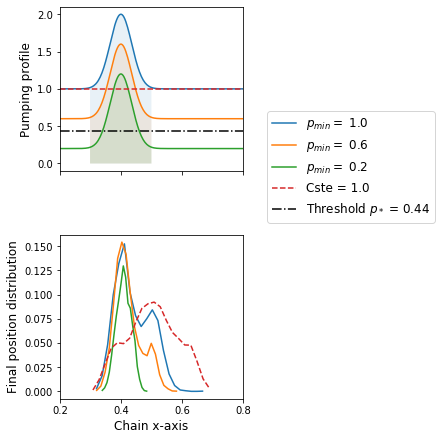

In [19]:
cste, gaussian = 1, 1
plot_threshold = 1

xmin, xmax = 0.2, 0.8

fig = plt.figure(constrained_layout=True, figsize=(6, 6))
gs = fig.add_gridspec(2, 1)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1:])

if gaussian :    
    #for k in gaussianpump.keys() :
    for k in [1.0, 0.6, 0.2] :
        
        if 1 :
        #if k in [0.3, 0.6, 1., 2.] :
            x = np.linspace(xmin, xmax, 201)
            amp, mu, sigma, fmin = 1.0, 0.4, 0.05, k
            ax1.plot(x, gaussian_profile(x, amp, mu, sigma, fmin), label = r'$p_{min} = $ '+str(k))
            i_start, i_stop = 33, 101
            ax1.fill_between(x[i_start:i_stop], 0., gaussian_profile(x[i_start:i_stop], amp, mu, sigma, fmin), alpha=0.1)

            xpos, ypos = gaussianpump[amp, mu, sigma, fmin][0]
            ax2.plot(xpos, ypos)
            
        
    if plot_threshold :
        Dx = (xmax - xmin)
        n = 2.
        threshold = sigma*amp*np.sqrt(np.pi) / (Dx - 4.*n*sigma) * erf(n)
        print('Threshold = ', threshold)
        
        ax1.hlines(xmin=xmin, xmax=xmax, y=threshold, color = 'k', linestyle='-.', label = r'Threshold $p_*$ = '+"{:2.2f}".format(threshold))

if cste :
    for k in cstepump.keys() :
        if k in [1.0] :
            x = np.linspace(xmin, xmax, 201)
            ax1.plot(x, np.ones(len(x))*k, linestyle='--', label='Cste = '+str(k))

            xpos, ypos = cstepump[k][0]
            ax2.plot(xpos, ypos, label = 'cste '+str(k), linestyle='--')
            
ax1.set_xticklabels([])

ax1.set_xlim(xmin, xmax)
ax2.set_xlim(xmin, xmax)

#ax[0].grid()
#ax[1].grid()

ax2.set_xlabel('Chain x-axis', fontsize=12)
ax1.set_ylabel('Pumping profile', fontsize=12)
ax2.set_ylabel('Final position distribution', fontsize=12)

ax1.legend(fontsize=12, bbox_to_anchor=(1.1, 0.4))
#plt.savefig('/Users/mathieuleverge/Documents/cavidoc/hydroosmotic/patterning/active_positioning.eps', formet='eps')
plt.show()


Threshold =  0.44104069538121066


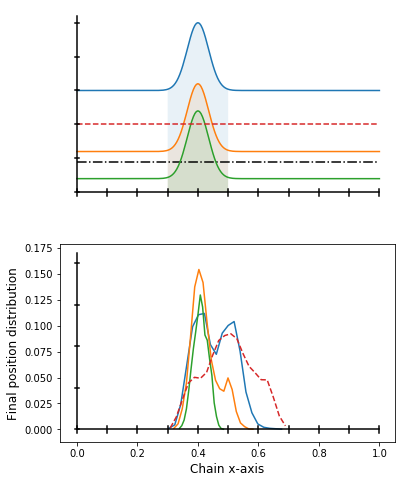

In [24]:
cste, gaussian = 1, 1
plot_threshold = 1

xmin, xmax = 0., 1.

fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax1 = ax[0]
ax2 = ax[1]
if gaussian :    
    #for k in gaussianpump.keys() :
    for k in [1.5, 0.6, 0.2] :
        
        if 1 :
        #if k in [0.3, 0.6, 1., 2.] :
            x = np.linspace(xmin, xmax, 201)
            amp, mu, sigma, fmin = 1.0, 0.4, 0.05, k
            ax1.plot(x, gaussian_profile(x, amp, mu, sigma, fmin), label = r'$p_{min} = $ '+str(k))
            i_start, i_stop = 60, 101
            ax1.fill_between(x[i_start:i_stop], 0., gaussian_profile(x[i_start:i_stop], amp, mu, sigma, fmin), alpha=0.1)

            xpos, ypos = gaussianpump[amp, mu, sigma, fmin][0]
            ax2.plot(xpos, ypos)
            
        
    if plot_threshold :
        Dx = (0.8 - 0.2)
        n = 2.
        threshold = sigma*amp*np.sqrt(np.pi) / (Dx - 4.*n*sigma) * erf(n)
        print('Threshold = ', threshold)
        
        ax1.hlines(xmin=xmin, xmax=xmax, y=threshold, color = 'k', linestyle='-.', label = r'Threshold $p_*$ = '+"{:2.2f}".format(threshold))

if cste :
    for k in cstepump.keys() :
        if k in [1.0] :
            x = np.linspace(xmin, xmax, 201)
            ax1.plot(x, np.ones(len(x))*k, linestyle='--', label='Cste = '+str(k))

            xpos, ypos = cstepump[k][0]
            ax2.plot(xpos, ypos, label = 'cste '+str(k), linestyle='--')
            
#ax1.set_xticklabels([])

#ax1.set_xlim(xmin, xmax)
#ax2.set_xlim(xmin, xmax)

ax1.plot((xmin, xmax), (0., 0.), color='k')
ax1.plot((xmin, xmin), (0., 2.6), color='k')

ax2.plot((xmin, xmax), (0., 0.), color='k')
ax2.plot((xmin, xmin), (0., 0.17), color='k')

t_width = 0.05
for xt in [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] :
    t_width = 0.05
    ax1.plot((xt, xt), (-t_width, t_width), color='k')
    ax2.plot((xt, xt), (-t_width/15., t_width/15.), color='k')
    
for yt in [0., 0.5, 1.0, 1.5, 2.0, 2.5] :
    ax1.plot((xmin-t_width/8., xmin+t_width/8.), (yt, yt), color='k')
    
for yt in [0., 0.04, 0.08, 0.12, 0.16] :
    ax2.plot((xmin-t_width/8., xmin+t_width/8.), (yt, yt), color='k')
    
ax1.axis('off')
#ax2.axis('off')
#ax2.grid()


ax2.set_xlabel('Chain x-axis', fontsize=12)
ax1.set_ylabel('Pumping profile', fontsize=12)
ax2.set_ylabel('Final position distribution', fontsize=12)

#ax1.legend(fontsize=12, bbox_to_anchor=(1.1, 0.4))

#plt.savefig('/Users/mathieuleverge/Documents/cavidoc/hydroosmotic/patterning/active_positioning.eps', formet='eps')
plt.show()

